On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.cross_decomposition import PLSRegression

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [5]:
%run Regression_GAM_Gamma.py

# Val croisée

In [6]:
n_knots = 10
max_compo = 100
max_lag = 7

for curr_compo in tqdm(range(1, max_compo+1)):
    for curr_lag in range(max_lag+1):
        
        cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})

        cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
        
        for curr_split in range(9):

            # Entrainnement
            curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
            curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
                #Standardisation Train_X
            curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
            for code in liste_stations_debit:
                curr_train_X_mean[code] = 0
            curr_train_X_std = curr_train_X[liste_stations_debit].std()
            curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
            curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_train_X_standard["Date"] = curr_train_X["Date"]
                #GAM
            spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
            curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                                   curr_train_X_standard, 
                                                                                   liste_stations_debit)
            curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, 
                                                      curr_train_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
            # Ajout AR
            colonnes_reg = colonnes_meteo_stations
            for i in range(curr_lag+1):
                variable = curr_train_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, variable], axis = 1)
                colonnes_reg = colonnes_reg + [code+"_"+str(i) for code in liste_stations_debit]
                
            # PLS
            curr_train_X_standard_residus = curr_train_X_standard_residus[(7+curr_lag):]
            model_PLS = PLSRegression(n_components=curr_compo)
            model_PLS.fit(X = curr_train_X_standard_residus[colonnes_reg],
                          Y = curr_train_X_standard_residus[liste_stations_debit])
            
            # Predictions GAM
            curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
            curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
            liste_dates = curr_test_Y["Date"]
                # Test_X standard
            curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                                  curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_test_X_standard["Date"] = curr_test_X["Date"].values
            curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit,
                                                                              curr_test_X_standard, 
                                                                              liste_stations_debit)
            curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, 
                                                      curr_test_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
                # Ajout variables AR
            for i in range(curr_lag+1):
                variable = curr_test_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, variable], axis = 1)

                # Pred PLS
            curr_test_X_standard_residus = curr_test_X_standard_residus[(7+curr_lag):]
            predictions_test_Y_standard_residus = model_PLS.predict(curr_test_X_standard_residus[colonnes_reg])
            predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
            predictions_test_Y_standard_residus["Date"] = curr_test_X_standard_residus["Date"].values

            # Filtre sur les dates
            resultat = pd.DataFrame()
            for curr_date in liste_dates:
                resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
            resultat = resultat.sort_values(by = "Date")
            predictions_test_Y_standard_residus = resultat.copy()

            # On rajoute la compo saisonnalité
            predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
            predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
            for code in liste_stations_debit:
                predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

            # Score standard
            curr_test_Y_standard = fct_Standardize(curr_test_Y, 
                                                   curr_train_X_mean, curr_train_X_std, 
                                                   liste_stations_debit)
            curr_test_Y_standard["Date"] = curr_test_Y["Date"]
            curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

            # Score
            predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                                   curr_train_X_mean, curr_train_X_std, liste_stations_debit)
            predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
            curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]

        cv_moyen_RMSE_standard = []
        cv_moyen_MAE_standard = []
        cv_moyen_R2_standard = []

        cv_moyen_RMSE = []
        cv_moyen_MAE = []
        cv_moyen_R2 = []

        for code in liste_stations_debit:
            score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE_standard.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE_standard.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2_standard.append(score_R2)
            score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2.append(score_R2)

        cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
        cv_scores_RMSE_standard.to_csv("../Data/GAMPLSAR/CV_RMSE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
        cv_scores_MAE_standard.to_csv("../Data/GAMPLSAR/CV_MAE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
        cv_scores_R2_standard.to_csv("../Data/GAMPLSAR/CV_R2_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
        cv_scores_RMSE.to_csv("../Data/GAMPLSAR/CV_RMSE_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE["Moyenne"] = cv_moyen_MAE
        cv_scores_MAE.to_csv("../Data/GAMPLSAR/CV_MAE_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2["Moyenne"] = cv_moyen_R2
        cv_scores_R2.to_csv("../Data/GAMPLSAR/CV_R2_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)    

  0%|                                                   | 0/100 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Selection

## Moyen

In [13]:
n_knots = 10
max_compo = 100
max_lag = 7

In [21]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMPLSAR/CV_RMSE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["N_Compo"] = curr_compo
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

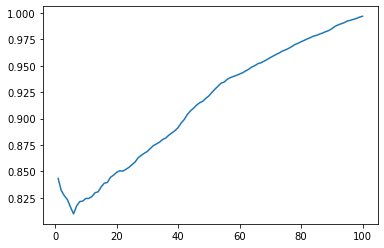

In [22]:
plt.plot(cv_moyen.groupby("N_Compo").mean().index, cv_moyen.groupby("N_Compo").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMPLSAR/GAMPLSAR_RMSE_PLS.png")

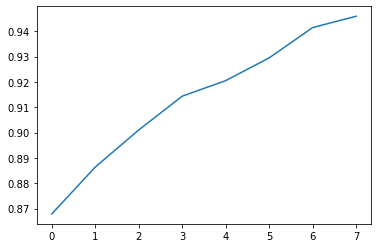

In [23]:
plt.plot(cv_moyen.groupby("Lags").mean().index, cv_moyen.groupby("Lags").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMPLSAR/GAMPLSAR_RMSE_AR.png")

In [28]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMPLSAR/CV_MAE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["N_Compo"] = curr_compo
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

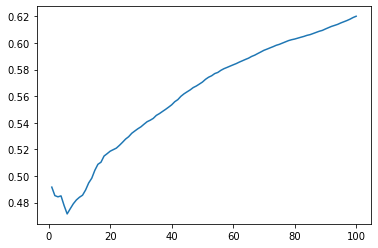

In [29]:
plt.plot(cv_moyen.groupby("N_Compo").mean().index, cv_moyen.groupby("N_Compo").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMPLSAR/GAMPLSAR_MAE_PLS.png")

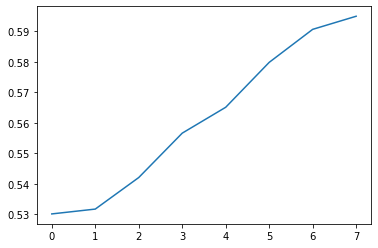

In [30]:
plt.plot(cv_moyen.groupby("Lags").mean().index, cv_moyen.groupby("Lags").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMPLSAR/GAMPLSAR_MAE_AR.png")

In [40]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMPLSAR/CV_R2_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["N_Compo"] = curr_compo
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

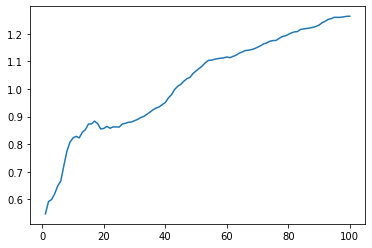

In [41]:
plt.plot(cv_moyen.groupby("N_Compo").mean().index, cv_moyen.groupby("N_Compo").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMPLSAR/GAMPLSAR_R2_PLS.png")

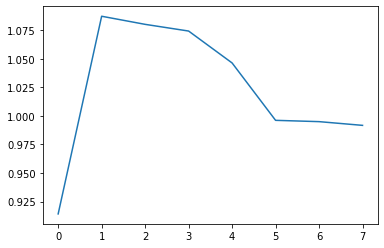

In [42]:
plt.plot(cv_moyen.groupby("Lags").mean().index, cv_moyen.groupby("Lags").mean()[liste_stations_debit].mean(axis = 1).values)
plt.savefig("../Data/Figures/GAMPLSAR/GAMPLSAR_R2_AR.png")

In [48]:
pd.read_csv("../Data/GAMPLSAR/CV_RMSE_standard_10_0.csv")["Moyenne"].mean()

0.8076795258342789

In [49]:
pd.read_csv("../Data/GAMPLSAR/CV_MAE_standard_10_0.csv")["Moyenne"].mean()

0.47565228063364207

In [50]:
pd.read_csv("../Data/GAMPLSAR/CV_R2_standard_10_0.csv")["Moyenne"].mean()

0.7733519831879424

# Test

In [9]:
n_compo = 15
n_knots = 10
max_compo = 100
max_lag = 0

In [10]:
# Entraintement
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
for code in liste_stations_debit:
    mesures_train_X_mean[code] = 0
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

In [11]:
spline_fit = fct_Regression_SplineGamma_fit(mesures_train_X_standard, liste_stations_debit, n_knots)
mesures_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                      mesures_train_X_standard, 
                                                                               liste_stations_debit)
model_PLS = PLSRegression(n_components=n_compo)
model_PLS.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
              Y = mesures_train_X_standard_residus[liste_stations_debit])

PLSRegression(n_components=15)

In [12]:
liste_dates = mesures_test_Y["Date"]
            # Test_X standard
mesures_test_X_standard =fct_Standardize(mesures_test_X, 
                                         mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values

In [13]:
# Pred
predictions_test_Y_standard_residus = model_PLS.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
predictions_test_Y_standard_residus["Date"] = mesures_test_X_standard["Date"].values
# Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard_residus = resultat.copy()

In [14]:
# On rajoute la compo saisonnalité
predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
for code in liste_stations_debit:
    predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values
    
mesures_test_Y

,Date,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,...,Temperature_07747,Humidite_07747,Precipitations_07747,Pression_07761,Vent_Nord_07761,Vent_Est_07761,Vitesse_vent_07761,Temperature_07761,Humidite_07761,Precipitations_07761
0,2020-01-15,32.558333,125.416667,303.500000,518.833333,0.962500,3.465000,9.922500,30.966667,33.968333,...,6.5750,78.125,0.000,102775.00,1.243892,0.617187,3.2125,8.4125,75.250,0.0000
1,2020-01-16,34.158333,116.583333,322.416667,507.250000,0.943333,3.218333,9.325000,29.525000,34.380000,...,7.7000,88.750,0.000,102920.00,1.959215,1.468298,2.4625,9.9750,76.875,-0.0125
2,2020-01-17,36.283333,128.500000,319.000000,546.166667,0.958333,3.280000,9.489167,27.950000,35.800000,...,9.4375,77.000,0.025,102647.50,0.066474,0.672485,2.6750,11.7250,81.500,0.0625
3,2020-01-18,38.525000,138.750000,345.583333,534.583333,0.927500,3.451667,11.091667,28.375000,70.450000,...,9.0250,62.500,0.000,102312.50,1.218467,-2.505142,3.8125,11.1000,68.875,0.0500
4,2020-01-19,34.666667,138.333333,335.083333,575.500000,0.888333,3.070000,9.660000,26.816667,68.816667,...,8.5250,46.625,0.000,102135.00,1.283513,1.229322,2.9000,7.2500,70.500,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2020-12-26,44.750000,204.250000,413.083333,602.083333,0.688333,3.330000,13.691667,37.325000,52.541667,...,6.2375,46.875,0.000,101011.25,2.315669,1.271815,2.9875,6.3750,74.625,0.0750
347,2020-12-27,41.291667,188.250000,378.833333,627.666667,0.672500,3.170000,13.083333,30.383333,69.258333,...,4.0625,58.375,0.000,100906.25,1.687684,0.985724,2.8000,5.9500,69.750,-0.0125
348,2020-12-28,51.316667,243.500000,425.666667,676.250000,0.683333,3.257500,13.516667,32.983333,85.591667,...,6.7000,60.875,0.000,99291.25,-3.083568,-4.526198,7.4750,11.5125,77.750,1.0375
349,2020-12-29,47.250000,552.666667,1474.750000,1975.833333,0.702500,3.126667,13.058333,35.491667,83.050000,...,8.4625,54.625,0.000,99955.00,2.336237,1.208835,2.7000,8.4250,89.250,0.3125


In [15]:
liste_stations_debit

['O0200020',
 'O2620010',
 'O6140010',
 'O9000010',
 'K0030020',
 'K0100020',
 'K0260020',
 'K0550010',
 'K0690010',
 'K0910050',
 'K4180010',
 'K4350020',
 'K6830020',
 'L8000020',
 'M5300010',
 'H0100010',
 'H0100020',
 'H0400010',
 'H0400020',
 'H0800011',
 'H0800012',
 'H0810010',
 'H1700010',
 'H3930020',
 'H4340020',
 'H5920014',
 'H8100021']

In [16]:
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

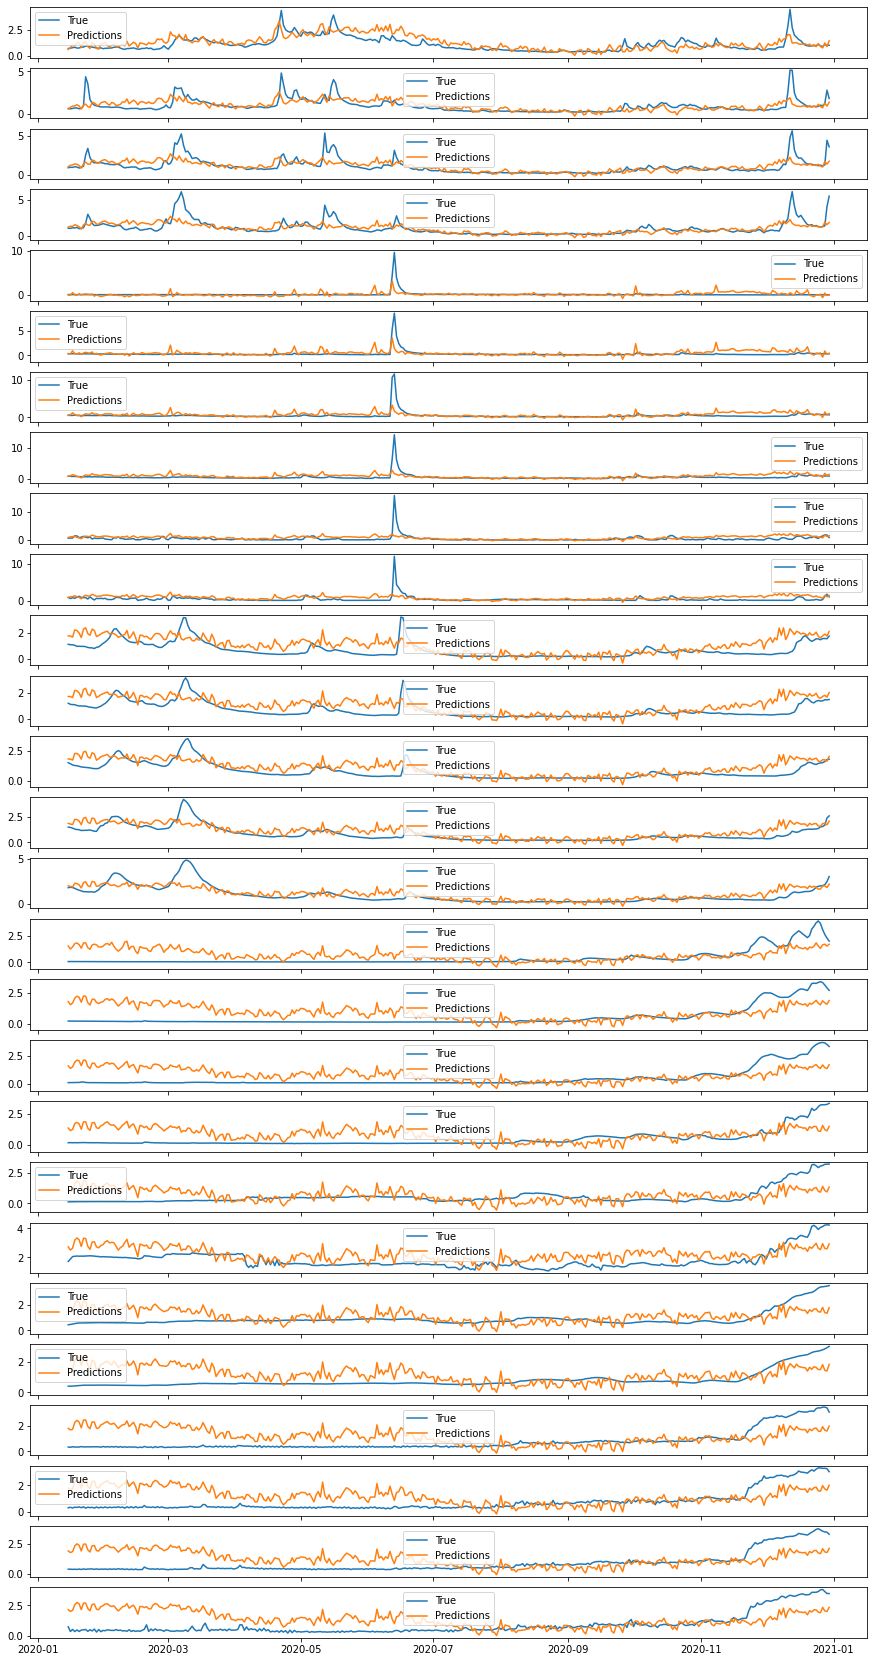

In [17]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    #axs[i].plot(predictions_test_Y_standard_saisonnalite["Date"], predictions_test_Y_standard_saisonnalite[code], label = "Saisonnalite")
    #axs[i].plot(predictions_test_Y_standard_residus["Date"], predictions_test_Y_standard_residus[code], label = "Residus")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [18]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard.to_csv("../Data/GAMPLSAR/Test_scores_standard.csv",
                   index = False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.517946,0.390563,0.996109
1,O2620010,0.655650,0.430930,0.485982
2,O6140010,0.711853,0.445001,0.428653
3,O9000010,0.772660,0.463364,0.380384
4,K0030020,0.628262,0.288632,0.433460
5,K0100020,0.664456,0.361094,0.565675
6,K0260020,0.905720,0.468306,0.323697
7,K0550010,1.005528,0.563744,0.324660
8,K0690010,1.096605,0.627393,0.262062
9,K0910050,0.945170,0.607639,0.312231


In [19]:
mesures_test_Y_standard


,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,K0910050,...,H0400020,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H5920014,H8100021,Date
0,0.701361,0.632733,0.922377,1.067086,0.156949,0.367997,0.535642,0.849975,0.759297,1.018458,...,0.166844,0.122865,1.722085,0.443003,0.401301,0.338441,0.323116,0.371741,0.769276,2020-01-15
1,0.735828,0.588169,0.979868,1.043263,0.153823,0.341800,0.503388,0.810404,0.768499,0.694462,...,0.173486,0.130083,1.885789,0.466541,0.405622,0.321065,0.364876,0.375400,0.385917,2020-01-16
2,0.781604,0.648289,0.969484,1.123303,0.156269,0.348349,0.512250,0.767173,0.800240,0.934609,...,0.164551,0.133840,2.057998,0.502150,0.410483,0.365268,0.305090,0.360175,0.556254,2020-01-17
3,0.829893,0.700001,1.050274,1.099479,0.151242,0.366581,0.598757,0.778839,1.574774,0.762148,...,0.171272,0.137818,2.081384,0.545002,0.422636,0.336054,0.373753,0.372394,0.380751,2020-01-18
4,0.746778,0.697899,1.018363,1.183633,0.144855,0.326047,0.521472,0.736065,1.538264,1.126697,...,0.165737,0.137744,2.096266,0.565523,0.438029,0.342832,0.350201,0.353444,0.514121,2020-01-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.963990,1.030452,1.255416,1.238307,0.112242,0.353660,0.739112,1.024499,1.174468,0.254434,...,3.257022,3.022266,4.064971,3.399171,2.738354,3.368177,3.300915,3.665132,3.751830,2020-12-26
347,0.889492,0.949731,1.151325,1.290924,0.109660,0.336667,0.706272,0.833963,1.548137,0.417226,...,3.264139,3.070145,4.124500,3.414863,2.784263,3.432142,3.271022,3.563850,3.781925,2020-12-27
348,1.105447,1.228470,1.293658,1.390845,0.111427,0.345960,0.729665,0.905328,1.913237,1.329898,...,3.276000,3.164430,4.222297,3.441419,2.843675,3.430233,3.277363,3.496545,3.611387,2020-12-28
349,1.017844,2.788231,4.481964,4.063702,0.114552,0.332065,0.704923,0.974177,1.856423,1.883361,...,3.297350,3.177689,4.245684,3.468578,2.921991,3.376769,3.246564,3.476942,3.455897,2020-12-29


In [20]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.790817
MAE     0.562972
R2      0.535689
dtype: float64

In [21]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                            mesures_train_X_mean, mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

In [22]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores.to_csv("../Data/GAMPLSAR/Test_scores.csv",
                   index = False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,24.043885,18.130561,0.996109
1,O2620010,129.959103,85.416295,0.485982
2,O6140010,234.228706,146.423750,0.428653
3,O9000010,375.679099,225.294529,0.380384
4,K0030020,3.852864,1.770057,0.433460
5,K0100020,6.256408,3.399999,0.565675
6,K0260020,16.777999,8.675127,0.323697
7,K0550010,36.633853,20.538585,0.324660
8,K0690010,49.058373,28.067417,0.262062
9,K0910050,54.576510,35.086626,0.312231
